In [30]:
import sys
sys.path.append("/home/jarlehti/projects/gradu")

In [31]:
import os
import glob
from dataclasses import dataclass
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import d3p
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.napsu_mq.napsu_mq import NapsuMQResult
from scripts.constants import TRAIN_DATASET_SIZE_MAP, TRUE_COEFFICIENTS_FOR_DATASETS
from src.napsu_mq.logistic_regression import logistic_regression
from src.napsu_mq.rubins_rules import conf_int, non_negative_conf_int
from src.utils.data_utils import dataframe_list_to_tensor
from src.utils.preprocess_dataset import get_binary4d_train
import pprint
from scipy.special import expit

In [32]:
CURRENT_FOLDER = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
DATASETS_FOLDER = os.path.join(CURRENT_FOLDER, "data", "datasets")
MODELS = os.path.join(CURRENT_FOLDER, "models")

In [33]:
model_files = glob.glob(os.path.join(MODELS, '*.dill'))

In [34]:
pprint.pprint([(i, m) for i, m in enumerate(model_files)])

[(0,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_10e_NUTS.dill'),
 (1,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB_10e_NUTS.dill'),
 (2,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary3d_empty_03e_NUTS.dill'),
 (3,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary3d_BC_80e_NUTS.dill'),
 (4,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AB+BC+CD_30e_NUTS.dill'),
 (5,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AD_01e_NUTS.dill'),
 (6,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_80e_NUTS.dill'),
 (7,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_AD_10e_NUTS.dill'),
 (8,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary3d_AB_30e_NUTS.dill'),
 (9,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_empty_03e_NUTS.dill'),
 (10,
  '/home/local/jarlehti/projects/gradu/models/napsu_binary4d_BC_01e_NUTS.dill'),
 (11,
  '/home/local/jarlehti/projects/gr

In [37]:
# Open random model
model_path = os.path.join(model_files[24])
model_binary = open(model_path, "rb")
model = NapsuMQResult.load(model_binary)

In [38]:
model.meta

{'experiment_id': 'NCWZWXE0',
 'dataset_name': 'binary4d',
 'query_str': 'AD+BD+CD',
 'query_list': [('A', 'D'), ('B', 'D'), ('C', 'D')],
 'epsilon': 50,
 'delta': 1e-10,
 'MCMC_algo': 'NUTS',
 'laplace_approximation': False,
 'missing_query': None,
 'n_canonical_queries': 7,
 'junction_tree_width': 2,
 'suff_stat_dim': (7,)}

In [39]:
dataset_name = model.meta['dataset_name']
n_original_datapoints = TRAIN_DATASET_SIZE_MAP[dataset_name]
print(n_original_datapoints)
true_params = TRUE_COEFFICIENTS_FOR_DATASETS[dataset_name]
print(true_params)

100000
[1.0, 0.0, 2.0]


In [40]:
orig_df = pd.read_csv(os.path.join(DATASETS_FOLDER, "binary4d.csv"))

In [41]:
orig_df

,A,B,C,D
0,1,1,0,1
1,0,0,1,1
2,1,1,0,0
3,1,1,1,1
4,0,0,1,1
...,...,...,...,...
99995,1,1,0,1
99996,1,1,1,1
99997,1,0,1,1
99998,1,0,1,1


In [43]:
orig_df_np = orig_df.to_numpy()
print(np.mean(orig_df_np, axis=0))

X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig = sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

[0.50029 0.49843 0.49868 0.76591]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45729.
Date:                Tue, 07 Feb 2023   Deviance:                       91457.
Time:                        15:22:48   Pearson chi2:                 1.00e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1595
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0

In [45]:
original_params = lr_model_orig.params
print(original_params)

[ 1.02258994 -0.01088867  1.99866304]


Generating data with 100000 points and 10 datasets


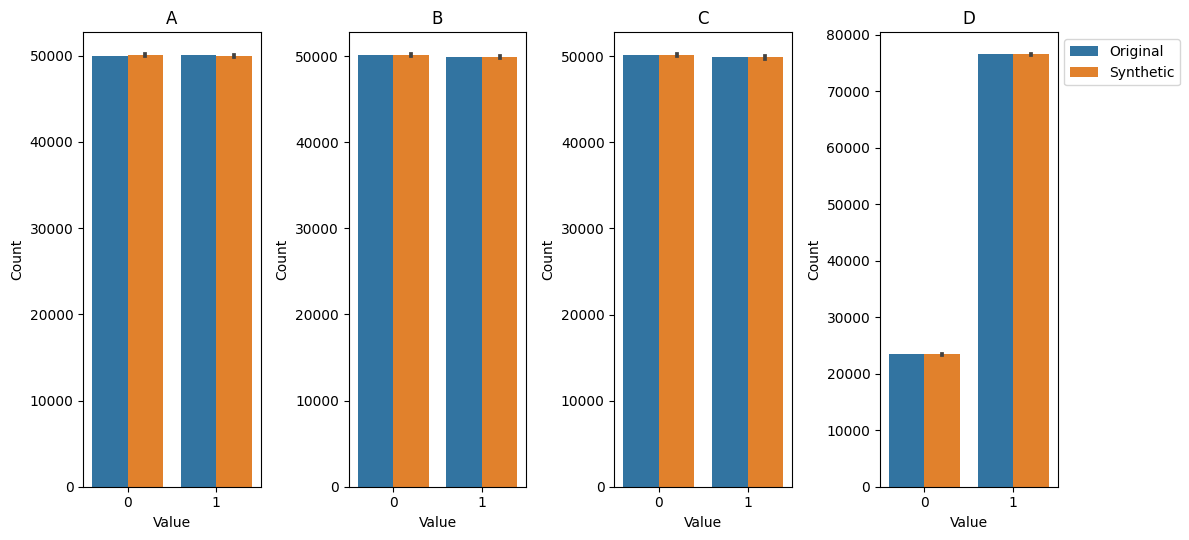

In [12]:
rng = jax.random.PRNGKey(32863812)
synthetic_dataset = model.generate(rng, n_original_datapoints, 10)


def value_count_list(df, col, type):
    counts = df[col].value_counts()
    return [(value, counts[value], type) for value in counts.index]

def value_count_df(orig_df, synthetic_dfs, col):
    vl_list = value_count_list(orig_df, col, "Original")
    for synthetic_df in synthetic_dfs:
        vl_list += (value_count_list(synthetic_df, col, "Synthetic"))

    return pd.DataFrame.from_records(vl_list, columns=["Value", "Count", "Type"])

value_count_dfs = { col: value_count_df(orig_df, synthetic_dataset, col) for col in orig_df.columns }

fig, axes = plt.subplots(1, len(value_count_dfs.items()), figsize=(3 * len(value_count_dfs.items()), 5.5))
for i, (key, value) in enumerate(value_count_dfs.items()):
    ax = axes[i]
    ax.set_title(key)
    ax.tick_params("x")
    sns.barplot(x="Value", y="Count", data=value_count_dfs[key], hue="Type", estimator=np.mean, ax=ax)
    if i < len(value_count_dfs.items()) - 1: 
        ax.get_legend().remove()
    else:
        ax.legend(loc="upper left", bbox_to_anchor=(1.00, 1))
        
plt.tight_layout()
plt.show()

In [13]:
synthetic_dataset[0]

,A,B,C,D
0,0,1,1,1
1,0,1,1,1
2,1,1,1,1
3,1,0,1,0
4,0,1,0,1
...,...,...,...,...
99995,1,0,0,0
99996,0,0,0,0
99997,0,0,1,0
99998,0,0,0,1


In [14]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
print(np.mean(synthetic_dfs_np, axis=0))
X_array_syn = synthetic_dfs_np[:,:-1]
y_array_syn = synthetic_dfs_np[:,-1]
lr_model_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
print(lr_model_syn.summary())

[0.49934  0.498548 0.498779 0.765242]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.6252e+05
Date:                Tue, 07 Feb 2023   Deviance:                   9.2504e+05
Time:                        14:08:31   Pearson chi2:                 1.00e+06
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1520
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            

In [15]:
synthetic_dfs_np = np.concatenate(synthetic_dataset, axis=0)
print(np.mean(synthetic_dfs_np, axis=0))
noisy_synthetic_df_np = synthetic_dfs_np + np.random.normal(size=synthetic_dfs_np.shape)
X_array_noisy_syn = noisy_synthetic_df_np[:,:-1]
y_array_noisy_syn = noisy_synthetic_df_np[:,-1]
lr_model_noisy_syn = sm.GLM(y_array_noisy_syn, X_array_noisy_syn, family=sm.families.Binomial()).fit()
print(lr_model_noisy_syn.summary())

[0.49934  0.498548 0.498779 0.765242]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:              1000000
Model:                            GLM   Df Residuals:                   999997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5874e+06
Date:                Tue, 07 Feb 2023   Deviance:                   3.7930e+07
Time:                        14:08:44   Pearson chi2:                 6.39e+06
No. Iterations:                     5   Pseudo R-squ. (CS):            -0.1008
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            

<AxesSubplot:>

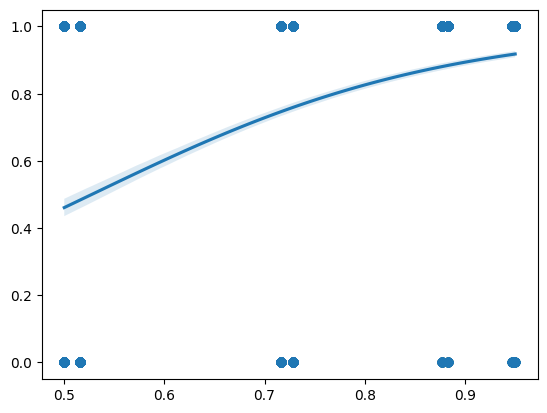

In [16]:
params = lr_model_syn.params
predictions = expit(synthetic_dfs_np[:,:-1] @ params)
sns.regplot(x=predictions[0:5000], y=synthetic_dfs_np[:,3][0:5000], logistic=True)

In [17]:
orig_df_np = orig_df.to_numpy()
X_array_orig = orig_df_np[:,:-1]
y_array_orig = orig_df_np[:,-1]
lr_model_orig =  sm.GLM(y_array_orig, X_array_orig, family=sm.families.Binomial()).fit()
print(lr_model_orig.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45729.
Date:                Tue, 07 Feb 2023   Deviance:                       91457.
Time:                        14:09:08   Pearson chi2:                 1.00e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1595
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0226      0.015     70.442      0.0

In [23]:
np.unique(synthetic_dfs_np)

array([0, 1], dtype=int32)

<AxesSubplot:>

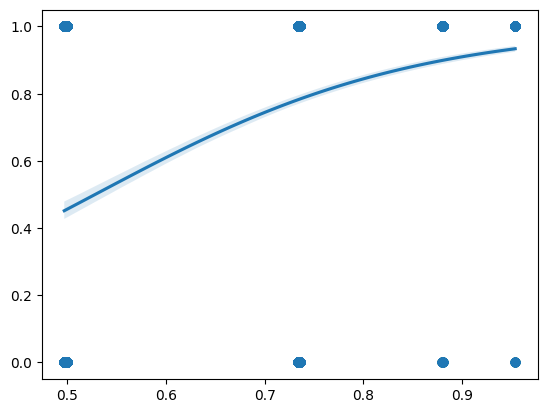

In [18]:
params_orig = lr_model_orig.params
predictions_orig = expit(orig_df_np[:,:-1] @ params_orig)

sns.regplot(x=predictions_orig[0:5000], y=orig_df_np[:,3][0:5000], logistic=True)

In [24]:
q = np.zeros((len(synthetic_dataset), 3))
u = np.zeros((len(synthetic_dataset), 3))

for i, syn_df in enumerate(synthetic_dataset):
    X_array_syn = syn_df.to_numpy()[:,:-1]
    y_array_syn = syn_df.to_numpy()[:,-1]
        
    logistic_regression_result_with_syn = sm.GLM(y_array_syn, X_array_syn, family=sm.families.Binomial()).fit()
    
    q[i, :] = logistic_regression_result_with_syn.params
    u[i, :] = logistic_regression_result_with_syn.bse**2
    
print(f"Expectation for param 1: {np.mean(q[:,0])}")
print(f"Expectation for param 2: {np.mean(q[:,1])}")
print(f"Expectation for param 3: {np.mean(q[:,2])}")
# print(f"Expectation for param 3: {np.mean(q[:,3])}")

Expectation for param 1: 0.9252587646303351
Expectation for param 2: 0.06099943291681949
Expectation for param 3: 1.9646410469665916


In [46]:
# How many repeats to calculate coverage
n_repeats = 20

confidence_intervals = np.round(np.linspace(0.05, 0.95, 10), 2)

n_datasets = [200]

In [47]:
@dataclass
class ConfidenceIntervalObject:
    original_dataset_name: str
    index: int
    n_datasets: int
    conf_int_range: float
    conf_int_start: float
    conf_int_end: float
    conf_int_width: float
    true_parameter_value: float
    contains_true_parameter: bool
        
    def to_dict(self):
        return {
            'original_dataset_name': self.original_dataset_name,
            'index': self.index,
            'n_datasets': self.n_datasets,
            'conf_int_range': self.conf_int_range,
            'conf_int_start': self.conf_int_start,
            'conf_int_end': self.conf_int_end,
            'conf_int_width': self.conf_int_width,
            'true_parameter_value': self.true_parameter_value,
            'contains_true_parameter': self.contains_true_parameter,
        }

In [50]:
rng = jax.random.PRNGKey(2356991365)
sampling_rngs = jax.random.split(rng, n_repeats * len(n_datasets))

ci_data_objects = []

for n in range(n_repeats):
    print(f"Round: {n}")
    for interval in confidence_intervals:
        for i, n_dataset in enumerate(n_datasets):
            print(f"Generating {n_dataset} datasets for interval {interval}")
            sampling_index = n + i
            datasets = model.generate(sampling_rngs[sampling_index], n_original_datapoints, n_dataset)
            datasets_np = dataframe_list_to_tensor(datasets)
            
            q, u = logistic_regression(datasets_np, add_constant=False)
            
            for d in range(len(true_params)):
                q_i = q[:,d]
                u_i = u[:,d]
                
                ci_result = conf_int(q_i, u_i, interval)
                nn_ci_result = non_negative_conf_int(q_i, u_i, interval, n_original_datapoints, n_original_datapoints)
                
                if np.isnan(ci_result[0]) or np.isnan(ci_result[1]) or np.isnan(nn_ci_result[0]) or np.isnan(nn_ci_result[1]):
                    print(f"WARNING: Confidence interval had nan: {ci_result}, nn {nn_ci_result}")

                true_param_value = true_params[d]
                
                print(f"True param value: {true_param_value}, confidence interval: {ci_result[0]} - {ci_result[1]}, nn confidence interval: {nn_ci_result[0]} - {nn_ci_result[1]}")
                
                conf_int_object = ConfidenceIntervalObject(
                    original_dataset_name = dataset_name,
                    index = n,
                    n_datasets = n_dataset,
                    conf_int_range = interval,
                    conf_int_start = ci_result[0],
                    conf_int_end = ci_result[1],
                    conf_int_width = ci_result[1] - ci_result[0],
                    true_parameter_value = true_param_value,
                    contains_true_parameter = ci_result[0] <= true_param_value <= ci_result[1]
                )
                
                ci_data_objects.append(conf_int_object)

Round: 0
Generating 200 datasets for interval 0.05
Generating data with 100000 points and 200 datasets
True param value: 1.0, confidence interval: 0.937974485963169 - 0.939569729765345, nn confidence interval: 0.937974485963169 - 0.939569729765345
True param value: 0.0, confidence interval: 0.04929904847599778 - 0.05085168563405343, nn confidence interval: 0.04929904847599778 - 0.05085168563405343
True param value: 2.0, confidence interval: 1.9648387162214633 - 1.9672244270322912, nn confidence interval: 1.9648387162214633 - 1.9672244270322912
Generating 200 datasets for interval 0.15
Generating data with 100000 points and 200 datasets
True param value: 1.0, confidence interval: 0.9363660193315252 - 0.9411781963969889, nn confidence interval: 0.9363660193315252 - 0.9411781963969889
True param value: 0.0, confidence interval: 0.04773360609561488 - 0.05241712801443633, nn confidence interval: 0.04773360609561488 - 0.05241712801443633
True param value: 2.0, confidence interval: 1.96243351

KeyboardInterrupt: 

In [27]:
ci_data_df = pd.DataFrame.from_records([obj.to_dict() for obj in ci_data_objects])

In [28]:
ci_data_df

,original_dataset_name,index,n_datasets,conf_int_range,conf_int_start,conf_int_end,conf_int_width,true_parameter_value,contains_true_parameter
0,binary4d,0,50,0.05,0.935949,0.938231,0.002283,1.0,False
1,binary4d,0,50,0.05,0.054213,0.055587,0.001374,0.0,False
2,binary4d,0,50,0.05,1.957917,1.960402,0.002485,2.0,False
3,binary4d,0,50,0.15,0.933646,0.940534,0.006888,1.0,False
4,binary4d,0,50,0.15,0.052826,0.056975,0.004149,0.0,False
...,...,...,...,...,...,...,...,...,...
595,binary4d,19,50,0.85,0.029739,0.078446,0.048707,0.0,False
596,binary4d,19,50,0.85,1.933933,1.985119,0.051187,2.0,False
597,binary4d,19,50,0.95,0.907561,0.969829,0.062268,1.0,False
598,binary4d,19,50,0.95,-0.025525,0.133710,0.159235,0.0,True


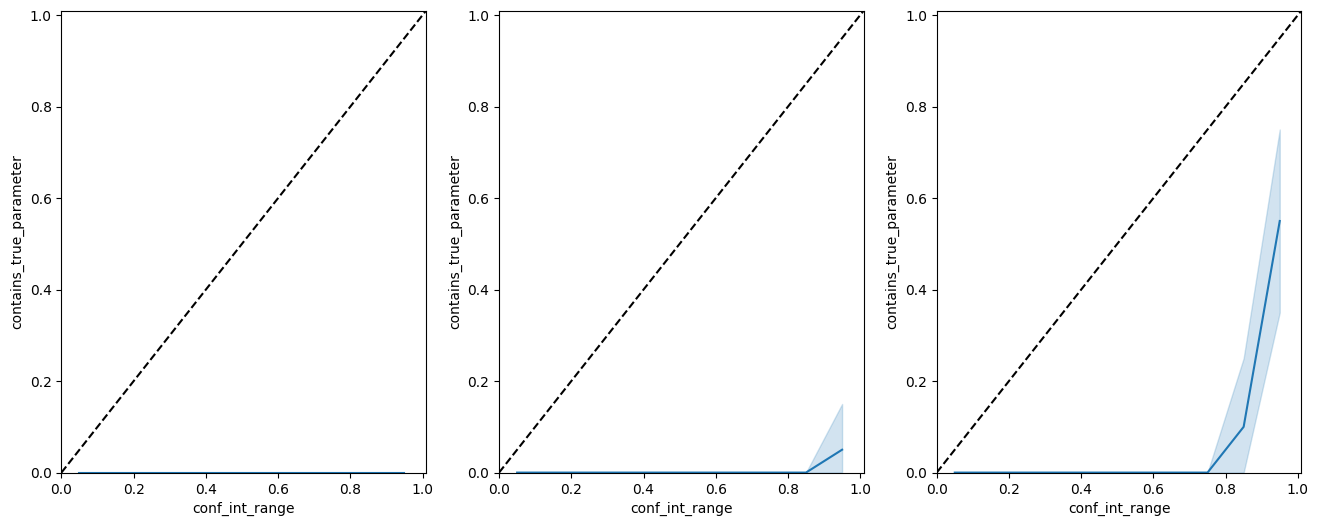

In [52]:
fig, axes = plt.subplots(1, len(true_params), figsize=(16, 6))

for i, param in enumerate(true_params):
    ax = axes[i]
    ci_data = ci_data_df[ci_data_df['true_parameter_value'] == param]
    sns.lineplot(x="conf_int_range", y="contains_true_parameter", markers=True, err_style="band", data=ci_data, ax=ax)
    diag = (0.0, 1.01)
    ax.plot(diag, diag, linestyle="dashed", color="black")
    ax.set_xlim(diag)
    ax.set_ylim(diag)
    #axes[0, i].set_title(f"True parameter: {param}")
    #axes[-1, i].set_xlabel("Conf Level")